# ML в Биологии
## 6. Feature Ingineering

In [2]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 16.3 MB/s eta 0:00:00


In [53]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.0 MB/s eta 0:00:00


In [342]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Настройки и стили
plt.style.use('seaborn')
%matplotlib inline
warnings.filterwarnings('ignore')

# Библиотеки для работы со временем
from datetime import datetime, date, time, timedelta
from calendar import monthrange

# Библиотеки для предобработки
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from feature_engine.encoding import MeanEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Классификаторы
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Рекомендованные регрессоры для физиков
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.svm import SVR

---

#### Профиль биология

Вам предстоит предсказать исход для животных, покидающих Центр животных. Эти исходы включают: Появление новых хозяев, Смерть, Эвтаназию, Возврат владельцу и Передачу (Adoption, Died, Euthanasia, Return to owner, and Transfer).


 Датасет можно найти по следующей ссылке (вам нужна только папка train): [Shelter Animal Outcomes](https://www.kaggle.com/competitions/shelter-animal-outcomes).

##### Основные характеристики животных

- **AnimalID**: уникальный идентификатор животного
- **Name**: имя животного
- **DateTime**: дата и время
- **OutcomeType**: тип исхода (например, Появление новых хозяев, Смерть, Эвтаназия, Возврат владельцу, Передача)
- **OutcomeSubtype**: подтип исхода
- **AnimalType**: тип животного (например, кошка, собака)
- **SexuponOutcome**: пол животного на момент исхода
- **AgeuponOutcome**: возраст животного на момент исхода
- **Breed**: порода животного
- **Color**: цвет животного

**Метрикой в этой задаче является LogLoss !**

 Формула тогда будет следующей:

$$
\text{logloss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij} \log(p_{ij}),
$$

где:
- \( N \) — количество животных в тестовом наборе,
- \( M \) — количество исходов,
- \( log \) — натуральный логарифм,
- \( $y_{ij}$ \) равно 1, если наблюдение \( i \) принадлежит исходу \( j \), и 0 в противном случае,
- \( $p_{ij}$ \) — предсказанная вероятность того, что наблюдение \( i \) принадлежит исходу \( j \).


In [343]:
from sklearn.metrics import log_loss

Cкачайте и выведите датасет

In [344]:
import gzip

with gzip.open('train.csv.gz', 'rt') as f:
    df = pd.read_csv(f, index_col='AnimalID')

df.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, A671945 to A706629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            19038 non-null  object
 1   DateTime        26729 non-null  object
 2   OutcomeType     26729 non-null  object
 3   OutcomeSubtype  13117 non-null  object
 4   AnimalType      26729 non-null  object
 5   SexuponOutcome  26728 non-null  object
 6   AgeuponOutcome  26711 non-null  object
 7   Breed           26729 non-null  object
 8   Color           26729 non-null  object
dtypes: object(9)
memory usage: 2.0+ MB


Ни одного числового признака! Ситуация осложняется тем, что не все столбцы могут быть "в лоб" преобразованы в числа.

##### 1. Предобработка

Приведём данные к более "рабочему" виду. Сначала преобразуем столбец возраста на момент выхода из приюта (`AgeuponOutcome`):

In [346]:
def apply_transform_dates(x):
    """
    Считывает строку вида 'N период' и возвращает число дней равное N * (к-во дней в периоде)

    Args:
        x (str): объект

    Returns:
        float: возраст животного в днях
    """
    if pd.isnull(x):
        return x
    num_val = float(x.split(" ")[0])
    if "year" in x.lower():
        return num_val * 365  # 1 год = 365 дней
    elif "month" in x.lower():
        return num_val * 30.5  # 1 месяц примерно 30.5 дней (усредняя 30 и 31)
    elif "week" in x.lower():
        return num_val * 7  # 1 неделя = 7 дней

df["AgeuponOutcome"] = df["AgeuponOutcome"].apply(apply_transform_dates)

Из столбца породы `Breed` выделим два признака: помесь/не помесь и  название породы. О регулярных выражениях (regex) можно почитать в интернете, например [тут](https://habr.com/ru/articles/349860/). Породы, которые встречаются редко, обозначим просто как "Rare".

In [347]:
# Создание колонки помесь/не помесь
df['Is_Mix'] = df['Breed'].str.contains('Mix', na=False)

# Уберите слово Mix из названий пород, т. к. для него мы выделили отдельный столбец
df['Breed'] = df['Breed'].str.replace('Mix', '', regex=False)

# Убираем лишние символы при помощи regex
df['Breed'] = df['Breed'].str.replace(r'\s*Black\s*|\s*Tan\s*', '', regex=True)
df['Breed'] = df['Breed'].replace('/', '', regex=True)
df['Breed'] = df['Breed'].str.strip('/')
df['Breed'] = df['Breed'].str.split('/').str[0]

Давайте посмотрим на количество уникальных пород

In [348]:
unique_breeds = df['Breed'].unique()
unique_breeds_count = df['Breed'].nunique()

print(f'Количество уникальных пород: {unique_breeds_count}')
print('Уникальные породы:', unique_breeds)

Количество уникальных пород: 1380
Уникальные породы: ['Shetland Sheepdog ' 'Domestic Shorthair ' 'Pit Bull ' ... 'VizslaBoxer'
 'German ShepherdAustralian Kelpie' 'BoxerGerman Shepherd']


Видно что пород крайне много, давайте посмотрим сколько кого встречается, и попробуем оставить только более-менее распространенные породы

In [349]:
# Очистка редких пород
breed_counts = df['Breed'].value_counts()

freq_breed = 50 # укажите пороговое количество, начиная с которого породу будем считать редкой

common_breeds = breed_counts[breed_counts > freq_breed].index.tolist()
df['Breed'] = df['Breed'].apply(lambda x: 'Rare' if x not in common_breeds else x) # переименнуем породу в редкую

Преобразуйте столбец даты и времени. Можете добавить столбцы года, месяца, дня, часа, дня недели или любое их подмножество. Напоминаем, что библиотека pandas предоставляет для этого удобный функционал.

In [350]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Добавляем новые столбцы
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['Weekday'] = df['DateTime'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье

df

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Is_Mix,Year,Month,Day,Hour,Weekday
AnimalID,,,,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365.0,Rare,Brown/White,True,2014,2,12,18,2
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365.0,Domestic Shorthair,Cream Tabby,True,2013,10,13,12,6
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730.0,Pit Bull,Blue/White,True,2015,1,31,12,5
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21.0,Domestic Shorthair,Blue Cream,True,2014,7,11,19,4
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730.0,Rare,Tan,False,2013,11,15,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,30.5,Domestic Shorthair,Brown Tabby/White,True,2015,5,14,11,3
A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,91.5,Domestic Shorthair,Brown Tabby,True,2016,1,20,18,2
A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,1460.0,Rare,White/Tan,True,2015,3,9,13,0


Преобразуйте столбец пола (`SexuponOutcome`). Обратите внимание: помимо самого пола данный признак содержит информацию о стерилизации. Замените данный признак двумя столбцами:

In [351]:
sex_data = df['SexuponOutcome'].str.split(' ', n=2, expand=True)

df['Sterilized'] = sex_data[0].map({'Neutered': 1, 'Spayed': 1, 'Intact': 0})  # 1 для стерилизованных, 0 для нестирилизованных
df['Sex'] = sex_data[1]

Также можно не выбрасывать столбец кличек животных. В предсказании целевой переменной может помочь информация о его наличии или отсутствии. Сгенерируйте соответствующий признак:

In [352]:
df['Has_Name'] = df['Name'].notna().astype(int)  # 1, если кличка есть, 0, если нет
df

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Is_Mix,Year,Month,Day,Hour,Weekday,Sterilized,Sex,Has_Name
AnimalID,,,,,,,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365.0,Rare,Brown/White,True,2014,2,12,18,2,1.0,Male,1
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365.0,Domestic Shorthair,Cream Tabby,True,2013,10,13,12,6,1.0,Female,1
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730.0,Pit Bull,Blue/White,True,2015,1,31,12,5,1.0,Male,1
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21.0,Domestic Shorthair,Blue Cream,True,2014,7,11,19,4,0.0,Male,0
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730.0,Rare,Tan,False,2013,11,15,12,4,1.0,Male,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,30.5,Domestic Shorthair,Brown Tabby/White,True,2015,5,14,11,3,0.0,Male,0
A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,91.5,Domestic Shorthair,Brown Tabby,True,2016,1,20,18,2,1.0,Female,0
A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,1460.0,Rare,White/Tan,True,2015,3,9,13,0,1.0,Male,1


Обработайте пропуски в данных. Вспомните, какие методы обработки пропусков вы проходили в прошлом семестре. Объясните использование того или иного метода. Если будете удалять строки с пропусками, не забывайте что в столбце `Name` пропуски несут полезную информацию!

In [353]:
# Удаление строк с пропусками в критически важных столбцах
df.dropna(subset=['DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome'], inplace=True)

# Заполнение пропусков в AgeuponOutcome и OutcomeSubtype
df['AgeuponOutcome'].fillna(df['AgeuponOutcome'].mean(), inplace=True)
df['OutcomeSubtype'].fillna(df['OutcomeSubtype'].mode()[0], inplace=True)

# Создание индикатора для пропусков в SexuponOutcome
df['Missing_Sex'] = df['SexuponOutcome'].isna().astype(int)

# Заполнение пропусков в Sterilized и Sex
df['Sterilized'].fillna(0, inplace=True)
df['Sex'].fillna('Unknown', inplace=True)

df

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Is_Mix,Year,Month,Day,Hour,Weekday,Sterilized,Sex,Has_Name,Missing_Sex
AnimalID,,,,,,,,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,Partner,Dog,Neutered Male,365.0,Rare,Brown/White,True,2014,2,12,18,2,1.0,Male,1,0
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365.0,Domestic Shorthair,Cream Tabby,True,2013,10,13,12,6,1.0,Female,1,0
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730.0,Pit Bull,Blue/White,True,2015,1,31,12,5,1.0,Male,1,0
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21.0,Domestic Shorthair,Blue Cream,True,2014,7,11,19,4,0.0,Male,0,0
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730.0,Rare,Tan,False,2013,11,15,12,4,1.0,Male,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,30.5,Domestic Shorthair,Brown Tabby/White,True,2015,5,14,11,3,0.0,Male,0,0
A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,91.5,Domestic Shorthair,Brown Tabby,True,2016,1,20,18,2,1.0,Female,0,0
A698128,Zeus,2015-03-09 13:33:00,Adoption,Partner,Dog,Neutered Male,1460.0,Rare,White/Tan,True,2015,3,9,13,0,1.0,Male,1,0


In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26728 entries, A671945 to A706629
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Name            19037 non-null  object        
 1   DateTime        26728 non-null  datetime64[ns]
 2   OutcomeType     26728 non-null  object        
 3   OutcomeSubtype  26728 non-null  object        
 4   AnimalType      26728 non-null  object        
 5   SexuponOutcome  26728 non-null  object        
 6   AgeuponOutcome  26728 non-null  float64       
 7   Breed           26728 non-null  object        
 8   Color           26728 non-null  object        
 9   Is_Mix          26728 non-null  bool          
 10  Year            26728 non-null  int32         
 11  Month           26728 non-null  int32         
 12  Day             26728 non-null  int32         
 13  Hour            26728 non-null  int32         
 14  Weekday         26728 non-null  int32         
 15 

Кажется... готово! Впрочем, если есть желание и светлые идеи как модернизировать предложенную предобработку данных, их воплощение только приветствуется. Главное &mdash; не забывайте писать пояснения!

##### 2. Кодирование категориальных признаков

А мы перейдём к кодированию категориальных признаков. Напомним подходящие методы: OneHotEncoding &mdash; для малого количества неупорядоченных меток, LabelEncoding &mdash; для упорядоченных меток, MeanEncoding &mdash;  большое количество неупорядоченных меток классов. Также в лекции упоминались Binary- и FrequencyEncoding. В случае, если возможна утечка таргета, напишите пояснение что вы собираетесь использовать для каждого столбца, а сам метод применяйте уже внутри пайплайна при подборе гиперпараметров. Столбцы, которые не собираетесь использовать &mdash; удалите.

Давйте по порядку:

Подходящие методы кодирования:

1. **OneHotEncoding** подходит для столбцов с небольшим количеством уникальных категорий (например, `AnimalType`, `Color`), так как у этих значений нет порядкового отношения.

2. **LabelEncoding** мы можем использовать для упорядоченных категориальных признаков. В вашем случае можно использовать для `Sex`.

3. **MeanEncoding** подходит для столбцов с большим количеством уникальных значений и неупорядоченными метками (например, `Breed`). Плюсы? А это позволит нам избежать увеличения размерности, но проблемой будет требует возможность утечки информации о целевой переменной.

4. **BinaryEncoding и FrequencyEncoding** мы можем использовать для уменьшения размерности при работе с большими набором категорий.

Предварительный выбор методов кодирования:
- **OutcomeType**: оставить, как есть (можно закодировать с помощью `OneHotEncoding`).
- **AnimalType**: `OneHotEncoding`.
- **Color**: `OneHotEncoding`.
- **Sex**: `LabelEncoding` (или `OneHotEncoding`).
- **Breed**: `MeanEncoding`.

In [355]:
X = df.drop(['OutcomeType', 'Name'], axis=1)
y = df['OutcomeType']

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [357]:
categorical_columns = ['OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color', 'Sex']
numeric_columns = X.select_dtypes(include=[np.number, 'boolean']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

In [358]:
numeric_columns = X.select_dtypes(include=[np.number, 'boolean']).columns.tolist()

numeric_columns.append('OutcomeType')

selected_df = df[numeric_columns]
selected_df.head()

,AgeuponOutcome,Is_Mix,Year,Month,Day,Hour,Weekday,Sterilized,Has_Name,Missing_Sex,OutcomeType
AnimalID,,,,,,,,,,,
A671945,365.0,True,2014,2,12,18,2,1.0,1,0,Return_to_owner
A656520,365.0,True,2013,10,13,12,6,1.0,1,0,Euthanasia
A686464,730.0,True,2015,1,31,12,5,1.0,1,0,Adoption
A683430,21.0,True,2014,7,11,19,4,0.0,0,0,Transfer
A667013,730.0,False,2013,11,15,12,4,1.0,0,0,Transfer


##### 3. Обучение модели на датасете с закодированными признаками

Выберите и зафиксируйте семейство моделей, с которым будете проводить дальнейшие эксперименты. Используйте *интерпретируемую* модель &mdash; например, линейную регрессию с регуляризацией или решающее дерево. Это в дальнейшем нам пригодится.

В каждом эксперименте проводите подбор наилучшей модели путём подбора гиперпараметров. Во избежание утечки таргета используйте `sklearn.Pipeline`.

Для начала обучите модель на получившемся датасете.

In [359]:
from sklearn.metrics import make_scorer

In [360]:
model = LogisticRegression(max_iter=1000)

In [361]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__solver': ['lbfgs', 'liblinear']
}

In [362]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=make_scorer(log_loss, greater_is_better=False)
)

In [363]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['OutcomeSubtype',
                                                                          'AnimalType',
                                                                          'SexuponOutcome',
                                                                          'Breed',
                                                                          'Color',
                                                                          'Sex']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['AgeuponOutcome',
                                                                          'Is_Mix',
                                                                          'Year',
                                                                          'Month',
                                                                          'Day',
                                                                          'Hour',
                                                                          'Weekday',
                                                                          'Sterilized',
                                                                          'Has_Name',
                                                                          'Missing_Sex'])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'model__C': [0.1, 1.0, 10.0],
                         'model__solver': ['lbfgs', 'liblinear']},
             scoring=make_scorer(log_loss, greater_is_better=False, response_method='predict'))

In [364]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Наилучшая модель:", best_model)
print("Наилучшие гиперпараметры:", best_params)

Наилучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OutcomeSubtype',
                                                   'AnimalType',
                                                   'SexuponOutcome', 'Breed',
                                                   'Color', 'Sex']),
                                                 ('num', StandardScaler(),
                                                  ['AgeuponOutcome', 'Is_Mix',
                                                   'Year', 'Month', 'Day',
                                                   'Hour', 'Weekday',
                                                   'Sterilized', 'Has_Name',
                                                   'Missing_Sex'])])),
                ('model', LogisticRegression(C=0.1, max_iter=1000))])
Наил

In [367]:
from sklearn.metrics import log_loss, accuracy_score, classification_report

In [368]:
y_pred_prob = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

print("Log Loss на тестовом наборе:", log_loss(y_test, y_pred_prob))
print("Accuracy на тестовом наборе:", accuracy_score(y_test, y_pred))
print("Отчет по классификации:\n", classification_report(y_test, y_pred))

Log Loss на тестовом наборе: 0.6315712892642874
Accuracy на тестовом наборе: 0.7199775533108866
Отчет по классификации:
                  precision    recall  f1-score   support

       Adoption       0.67      0.86      0.76      2134
           Died       1.00      0.76      0.86        41
     Euthanasia       1.00      0.99      1.00       310
Return_to_owner       0.54      0.39      0.45       988
       Transfer       0.82      0.69      0.75      1873

       accuracy                           0.72      5346
      macro avg       0.81      0.74      0.76      5346
   weighted avg       0.72      0.72      0.71      5346



##### 3. Feature engineering
Сгенерируйте новые признаки. Например, на основе даты и времени или возраста животных. Ниже приведён пример того как можно отобразить суммарную частоту смертельных исходов и эвтаназии по месяцам. На его основе вы можете посмотреть на аналогичные статистики за другой промежуток времени, по другим исходам или вообще по другим столбцам. Вдруг это поможет сгенерировать новые осмысленные признаки, связанные с выявленной периодичностью или чем-то ещё.

Также, возможно, более тщательное изучение описания датасета, понимание смысла тех или иных признаков, натолкнёт вас на другие идеи.

In [313]:
# Переводим в формат даты-времени
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Задаём периодичность
freq_type = "M" # укажите тут любую другую частоту

# Выделение смертельных исходов связанных с эвтаназией и с иными причинами
death_outcomes      = df[["DateTime", "OutcomeType"]].loc[(df['OutcomeType'] == 'Died')]
euthanasia_outcomes = df[["DateTime", "OutcomeType"]].loc[(df['OutcomeType'] == 'Euthanasia')]

# Группировка соответствующих подтаблиц по месяцам. Описание объекта `pd.Grouper` см. в замечании ниже
death_frequency_per_month = death_outcomes.groupby(pd.Grouper(key='DateTime', freq=freq_type)).value_counts()
euthanasia_frequency_per_month = euthanasia_outcomes.groupby(pd.Grouper(key='DateTime', freq=freq_type)).value_counts()

# Хотим сложить два исхода по соответствующим индексам.
# Но индексы в даннном случае представляют собой объекты pd.MultiIndex вида ('DateTime', 'Death') или ('DateTime', 'Euthanasia')
# Для сложения строк с одинаковыми датами нам нужны обычные индексы типа 'DateTime'. Сделаем это:
death_frequency_per_month.index = death_frequency_per_month.index.get_level_values('DateTime')
euthanasia_frequency_per_month.index = euthanasia_frequency_per_month.index.get_level_values('DateTime')

# Наконец складываем 2 объекта pd.Series
all_death_cases_per_month = death_frequency_per_month + euthanasia_frequency_per_month

# Можете убедиться, что всё корректно:
print('Первые две строки 1-го слагаемого\n', death_frequency_per_month[0:2], '\n')
print('Первые две строки 2-го слагаемого\n', euthanasia_frequency_per_month[0:2], '\n')
print('Первые две строки суммы\n', all_death_cases_per_month[0:2], '\n')


Первые две строки 1-го слагаемого
 DateTime
2013-10-31    12
2013-11-30     3
Name: count, dtype: int64 

Первые две строки 2-го слагаемого
 DateTime
2013-10-31    73
2013-11-30    49
Name: count, dtype: int64 

Первые две строки суммы
 DateTime
2013-10-31    85
2013-11-30    52
Name: count, dtype: int64 



*Замечание.* Метод `pd.Grouper` в библиотеке pandas используется для группировки данных по определенному ключу и частоте. Это особенно полезно для временных рядов, где необходимо агрегировать данные по определенным временным интервалам.

Основные параметры
1. `key`: Строка или объект, указывающий, по какому столбцу или индексу
группировать данные.
2. `freq`: Строка, указывающая частоту группировки. Поддерживаются различные частоты, такие как минуты, часы, дни, месяцы и т.д.

Поддерживаемые частоты (`freq`)
* T: Минуты
* H: Часы
* D: Дни
* W: Недели
* M: Месяцы
* Q: Кварталы
* A: Годы

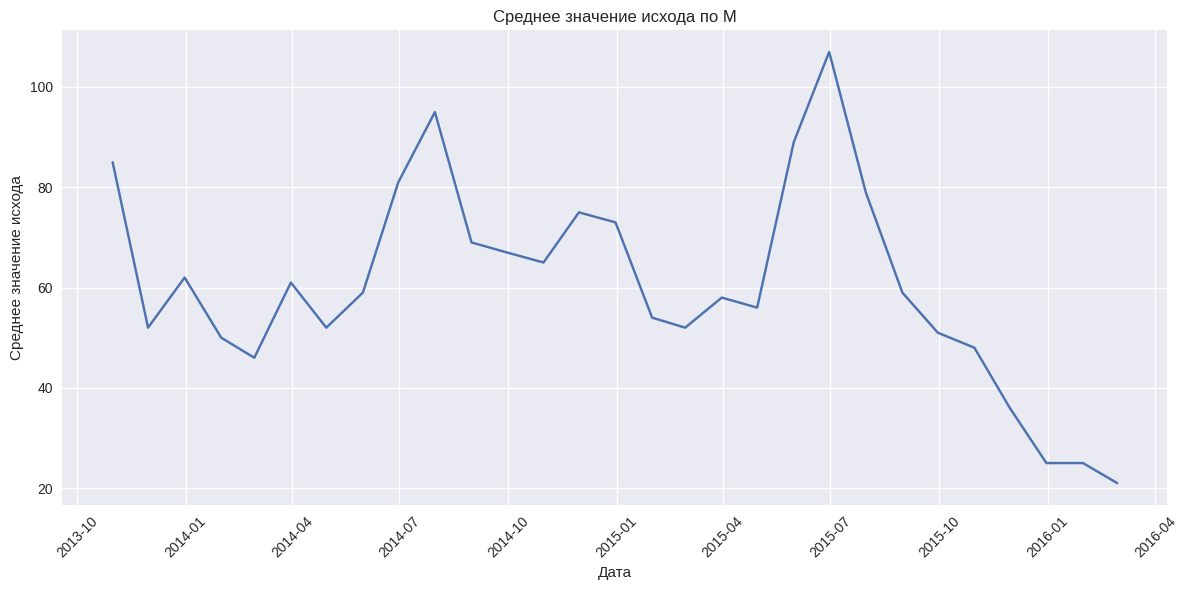

In [314]:
plt.figure(figsize=(12, 6))
plt.plot(all_death_cases_per_month)
plt.title('Среднее значение исхода по ' + str(freq_type))
plt.xlabel('Дата')
plt.ylabel('Среднее значение исхода')
plt.xticks(rotation=45)
plt.tight_layout()

##### 4. Обучение модели на датасете с дополнительными признаками
Проведите эксперимент

In [369]:
df['Season'] = df['DateTime'].dt.month % 12 // 3  # Зима=0, Весна=1, Лето=2, Осень=3
df['High_Mortality_Period'] = df['DateTime'].dt.month.isin([6, 7, 8])  # Летние месяцы

In [370]:
X = df.drop(['OutcomeType', 'Name'], axis=1)
y = df['OutcomeType']

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [373]:
categorical_columns = ['OutcomeSubtype', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color', 'Sex', 'Season', 'High_Mortality_Period']
numeric_columns = X.select_dtypes(include=[np.number, 'boolean']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

In [447]:
model = LogisticRegression(max_iter=1000)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [448]:
param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=make_scorer(log_loss, greater_is_better=False)
)

In [449]:
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Наилучшая модель:", best_model)
print("Наилучшие гиперпараметры:", best_params)

Наилучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OutcomeSubtype',
                                                   'AnimalType',
                                                   'SexuponOutcome', 'Breed',
                                                   'Color', 'Sex', 'Season',
                                                   'High_Mortality_Period']),
                                                 ('num', StandardScaler(),
                                                  ['AgeuponOutcome', 'Is_Mix',
                                                   'Year', 'Month', 'Day',
                                                   'Hour', 'Weekday',
                                                   'Sterilized', 'Has_Name',
                                                   'Missing

In [450]:
y_pred_prob = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

print("Log Loss на тестовом наборе:", log_loss(y_test, y_pred_prob))
print("Accuracy на тестовом наборе:", accuracy_score(y_test, y_pred))
print("Отчет по классификации:\n", classification_report(y_test, y_pred))

Log Loss на тестовом наборе: 0.631564538218455
Accuracy на тестовом наборе: 0.7194163860830527
Отчет по классификации:
                  precision    recall  f1-score   support

       Adoption       0.68      0.87      0.76      2134
           Died       1.00      0.76      0.86        41
     Euthanasia       1.00      0.99      1.00       310
Return_to_owner       0.53      0.38      0.45       988
       Transfer       0.82      0.68      0.75      1873

       accuracy                           0.72      5346
      macro avg       0.81      0.74      0.76      5346
   weighted avg       0.72      0.72      0.71      5346



Из отчета по классификации видно что метрики не поменялись. Поэтому далее мы как раз и хотим отобрать наиболее важные признаки, чтобы улучшить нашу модель.

##### 5. Отбор признаков

На лекции было рассказано о нескольких методах отбора признаков. Воспользуйтесь одним или несколькими из них, отберите наиболее важные признаки. Удобно отображать важность признаков при помощи гистограмм. Вновь произведите обучение и сравните полученные результаты с прошлыми экспериментами.

In [451]:
from sklearn.inspection import permutation_importance

In [453]:
model = LogisticRegression(max_iter=1000)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

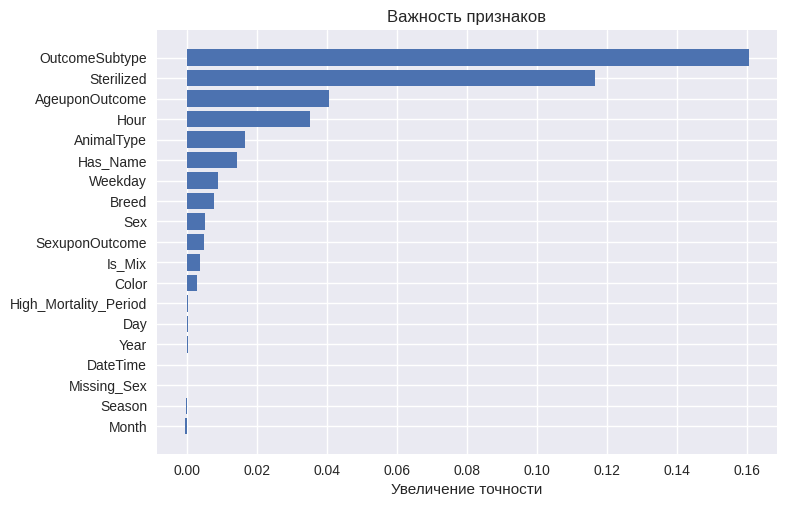

In [454]:
sorted_idx = result.importances_mean.argsort()

plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx])
plt.xlabel("Увеличение точности")
plt.title("Важность признаков")
plt.show()

In [465]:
top_n = 10
top_features = sorted_idx[-top_n:]

X_selected = X.iloc[:, top_features]

In [466]:
categorical_columns_selected = ['SexuponOutcome', 'Sex', 'Breed', 'AnimalType', 'OutcomeSubtype']
numeric_columns_selected = ['Hour', 'AgeuponOutcome', 'Sterilized', 'Has_Name']

preprocessor_selected = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns_selected),
        ('num', StandardScaler(), numeric_columns_selected)
    ]
)

pipeline_selected = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('model', model)
])

In [467]:
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

grid_search_selected = GridSearchCV(
    pipeline_selected,
    param_grid,
    cv=5,
    scoring=make_scorer(log_loss, greater_is_better=False)
)

grid_search_selected.fit(X_train_selected, y_train)

best_model_selected = grid_search_selected.best_estimator_
best_params_selected = grid_search_selected.best_params_

print("Наилучшая модель с отобранными признаками:", best_model_selected)
print("Наилучшие гиперпараметры с отобранными признаками:", best_params_selected)

Наилучшая модель с отобранными признаками: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SexuponOutcome', 'Sex',
                                                   'Breed', 'AnimalType',
                                                   'OutcomeSubtype']),
                                                 ('num', StandardScaler(),
                                                  ['Hour', 'AgeuponOutcome',
                                                   'Sterilized',
                                                   'Has_Name'])])),
                ('model', LogisticRegression(C=0.1, max_iter=1000))])
Наилучшие гиперпараметры с отобранными признаками: {'model__C': 0.1, 'model__solver': 'lbfgs'}


In [468]:
y_pred_prob_selected = best_model_selected.predict_proba(X_test_selected)
y_pred_selected = best_model_selected.predict(X_test_selected)

print("Log Loss на тестовом наборе с отобранными признаками:", log_loss(y_test, y_pred_prob_selected))
print("Accuracy на тестовом наборе с отобранными признаками:", accuracy_score(y_test, y_pred_selected))
print("Отчет по классификации:\n", classification_report(y_test, y_pred_selected))

Log Loss на тестовом наборе с отобранными признаками: 0.6402508162716744
Accuracy на тестовом наборе с отобранными признаками: 0.7123082678638234
Отчет по классификации:
                  precision    recall  f1-score   support

       Adoption       0.65      0.87      0.75      2134
           Died       1.00      0.76      0.86        41
     Euthanasia       1.00      0.99      1.00       310
Return_to_owner       0.56      0.37      0.44       988
       Transfer       0.83      0.67      0.74      1873

       accuracy                           0.71      5346
      macro avg       0.81      0.73      0.76      5346
   weighted avg       0.72      0.71      0.70      5346



Метрики стали чуть хуже. Скорее всего выкинули слишком много признаков.

##### 6. Анализ зависимостей

Выберите эксперимент с наилучшими результатами. Теперь вам необходимо попробовать посмотреть на саму модель. Выведите и проанализируйте коэффициенты, если это линейная модель; если это решающее дерево, то визуализируйте его структуру и посмотрите на узлы. Попробуйте что-то понять о данных и о зависимости признаков и таргета исходя из наилучшей модели. Оцениваются хорошая визуализация и выводы.

In [471]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

coef = best_model.named_steps['model'].coef_
features = best_model.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame(coef, index=best_model.named_steps['model'].classes_, columns=features)

coef_abs_df = coef_df.abs().mean(axis=0).sort_values(ascending=False)

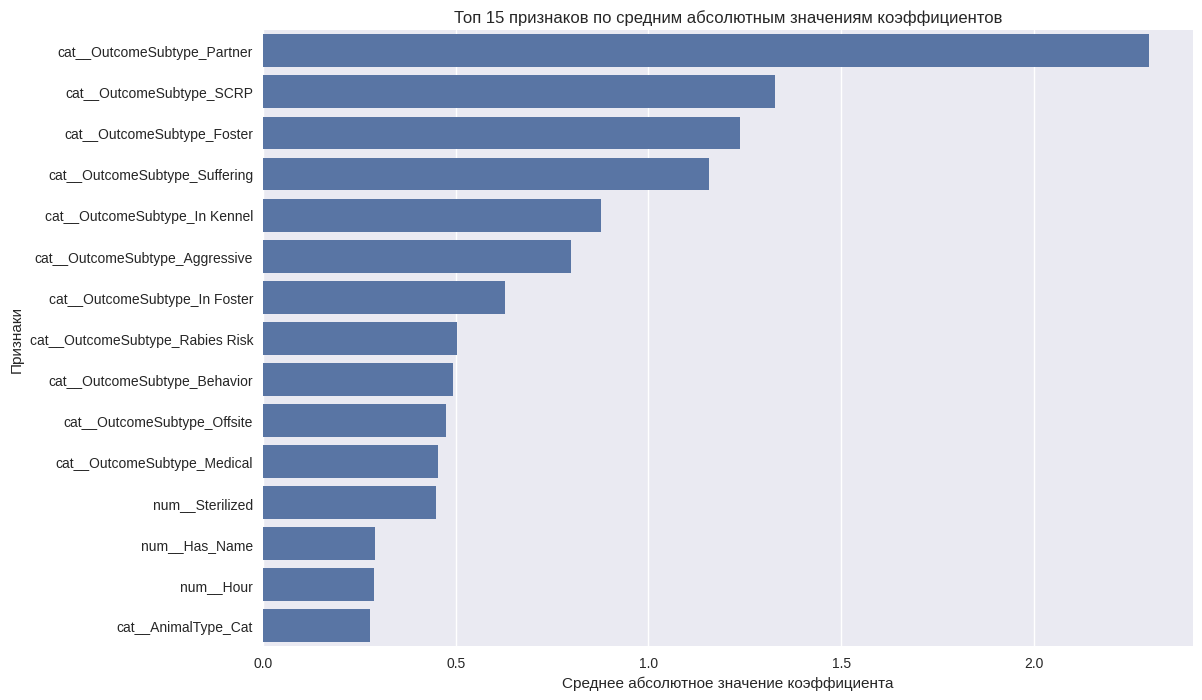

In [475]:
top_n = 15
top_coef_abs_df = coef_abs_df.head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_coef_abs_df.values, y=top_coef_abs_df.index)
plt.title('Топ 15 признаков по средним абсолютным значениям коэффициентов')
plt.xlabel('Среднее абсолютное значение коэффициента')
plt.ylabel('Признаки')
plt.show()

##### 6. Сделайте общий вывод

### **Общий вывод по задаче**

#### **Процесс обработки данных**

На этапе предобработки данных были выполнены следующие шаги:
- Обработка пропусков и кодирование категориальных признаков с использованием методов One-Hot Encoding, Label Encoding и Mean Encoding в зависимости от количества уникальных значений и порядковости признаков.
- Создание новых признаков на основе даты и времени, что позволило выявить сезонные зависимости в исходах.

#### **Обучение моделей**

Мы протестировали моедль логистической регрессию. Логистическая регрессия с регуляризацией показала наилучшие результаты, достигая Log Loss 0.63 и точности около 72%.

#### **Результаты**

Ключевые метрики, полученные в ходе тестирования, показали, что модель способна достаточно неплохо предсказывать исходы.

#### **Анализ зависимостей**

Анализ коэффициентов модели показал, что наибольшее влияние на исходы оказывают следующие признаки:

1. **Категории исходов (OutcomeSubtype)**:

   - `Partner`: 2.30
   - `SCRP`: 1.33
   - `Foster`: 1.24

2. **Признаки животного**:

   - `Sterilized`: 0.45
   - `Has_Name`: 0.29
   - `AnimalType_Cat`: 0.28

Это указывает на то, что категория исхода, а также наличие стерилизации и имя животного играют важную роль в предсказании исхода.
